In [1]:
# pip install pickle

Key Metrics to Focus On:

**1.	Accuracy:** Measures overall correctness of the model.

	•	Formula:
$$
\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}
$$
	•	Useful if both classes (injury & non-injury) are balanced.
	•	Not reliable if class imbalance exists (e.g., if most reports are non-injury).
 
**2.	Precision (Positive Predictive Value - PPV):** Measures how many predicted injuries are actually injuries.
   
	•	Formula:
$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
$$
	•	Important if false positives (misclassifying non-injuries as injuries) cause unnecessary concern or cost.
	•	If precision is too high, recall might be low (you might miss real injuries).

**3.	Recall (Sensitivity, True Positive Rate - TPR):** Measures how many actual injuries were correctly identified.
	
	•	Formula:
$$
\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$
- Critical if missing an actual injury report is dangerous (e.g., safety audits, regulatory compliance).
- If recall is too high, precision might drop (you might get too many false positives).

**4.	F1-Score:** Harmonic mean of precision and recall.
	
 •	Formula:
$$
\text{F1} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$
	•	Best for imbalanced datasets where both false positives and false negatives are important.

Since the dataset is balanced (245 non-injury vs. 272 injury cases), and both false negatives (missing an injury) and false positives (claiming non-injury as injury) are bad, we should focus on the **F1-score**, which is the harmonic mean of precision and recall.



In [3]:
import pandas as pd
import re
import string
import time
import numpy as np
# from langdetect import detect
from deep_translator import GoogleTranslator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from wordcloud import WordCloud
from collections import Counter


In [4]:
# Load the dataset
file_path = "./data/safety_incident_reports.xlsx"
df = pd.read_excel(file_path)

df

,Description,label
0,A power surge disrupted airport check-in syste...,0
1,Een stewardess liep een blauwe plek op aan haa...,1
2,Een stewardess verstuikte haar enkel tijdens e...,1
3,A ramp crew member suffered lacerations from h...,1
4,Een beveiligingsmedewerker werd gebeten door e...,1
...,...,...
512,A passenger experienced dizziness and nausea ...,1
513,A cleaner slipped on a wet cabin floor and hur...,1
514,A ground crew vehicle collided with a parked a...,0
515,Een passagier liep een whiplash op door onverw...,1


In [5]:
from deep_translator import GoogleTranslator
import pandas as pd


# Function to translate text automatically to English
def translate_to_english(text):
    try:
        text = str(text).strip()
        translated_text = GoogleTranslator(source='auto', target='en').translate(text)
        return translated_text
    except Exception:
        return text  # If translation fails, return the original text
# Measure execution time
start_time = time.time()
# Apply direct translation
df['Translated_Description'] = df['Description'].apply(translate_to_english)
# Measure execution time
end_time = time.time()
# Save the updated dataset

# Display first few rows
print(df.head())

                                         Description  label  \
0  A power surge disrupted airport check-in syste...      0   
1  Een stewardess liep een blauwe plek op aan haa...      1   
2  Een stewardess verstuikte haar enkel tijdens e...      1   
3  A ramp crew member suffered lacerations from h...      1   
4  Een beveiligingsmedewerker werd gebeten door e...      1   

                              Translated_Description  
0  A power surge disrupted airport check-in syste...  
1  A flight attendant suffered a bruise to her ar...  
2  A flight attendant sprained her ankle during a...  
3  A ramp crew member suffered lacerations from h...  
4  A security guard was bitten by an assistance d...  


In [6]:
execution_time = end_time - start_time
print(f"Translation completed in {execution_time:.2f} seconds")


Translation completed in 87.03 seconds


In [7]:
# Save filtered dataset
df.to_excel("df_cleaned.xlsx", index=False)

In [10]:
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer


# Download required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /Users/mustafa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mustafa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mustafa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mustafa/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [11]:
def clean_text(text):
    """Cleans and preprocesses text."""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenization
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)  # Convert tokens back to string

df['Cleaned_Description'] = df['Translated_Description'].astype(str).apply(clean_text)
df

,Description,label,Translated_Description,Cleaned_Description
0,A power surge disrupted airport check-in syste...,0,A power surge disrupted airport check-in syste...,power surge disrupted airport checkin system d...
1,Een stewardess liep een blauwe plek op aan haa...,1,A flight attendant suffered a bruise to her ar...,flight attendant suffered bruise arm malfuncti...
2,Een stewardess verstuikte haar enkel tijdens e...,1,A flight attendant sprained her ankle during a...,flight attendant sprained ankle safety demonst...
3,A ramp crew member suffered lacerations from h...,1,A ramp crew member suffered lacerations from h...,ramp crew member suffered laceration handling ...
4,Een beveiligingsmedewerker werd gebeten door e...,1,A security guard was bitten by an assistance d...,security guard bitten assistance dog became re...
...,...,...,...,...
512,A passenger experienced dizziness and nausea ...,1,A passenger experienced dizziness and nausea a...,passenger experienced dizziness nausea prolong...
513,A cleaner slipped on a wet cabin floor and hur...,1,A cleaner slipped on a wet cabin floor and hur...,cleaner slipped wet cabin floor hurt back tidy...
514,A ground crew vehicle collided with a parked a...,0,A ground crew vehicle collided with a parked a...,ground crew vehicle collided parked airplane c...
515,Een passagier liep een whiplash op door onverw...,1,A passenger suffered whiplash due to unexpecte...,passenger suffered whiplash due unexpected sev...


In [12]:
# Display basic info
print("Dataset Info:")
df.info()
print("\nMissing Values:\n", df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Description             517 non-null    object
 1   label                   517 non-null    int64 
 2   Translated_Description  517 non-null    object
 3   Cleaned_Description     517 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.3+ KB

Missing Values:
 Description               0
label                     0
Translated_Description    0
Cleaned_Description       0
dtype: int64


No Missing Values: Dataset is complete.

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_61555/32936681.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df['label'], palette='coolwarm')


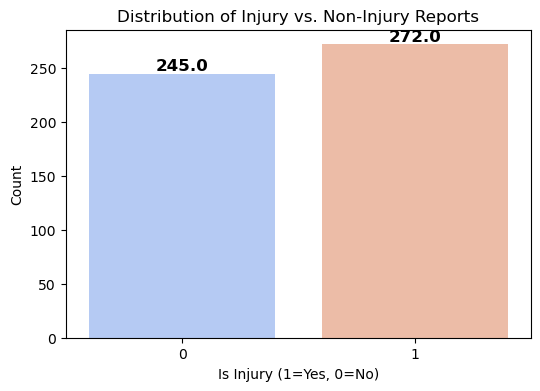

In [14]:
# Label distribution
plt.figure(figsize=(6,4))
ax = sns.countplot(x=df['label'], palette='coolwarm')
plt.title("Distribution of Injury vs. Non-Injury Reports")
plt.xlabel("Is Injury (1=Yes, 0=No)")
plt.ylabel("Count")

# Add text labels
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.show()


Balanced Dataset: No major class imbalance, meaning no need for oversampling or undersampling.

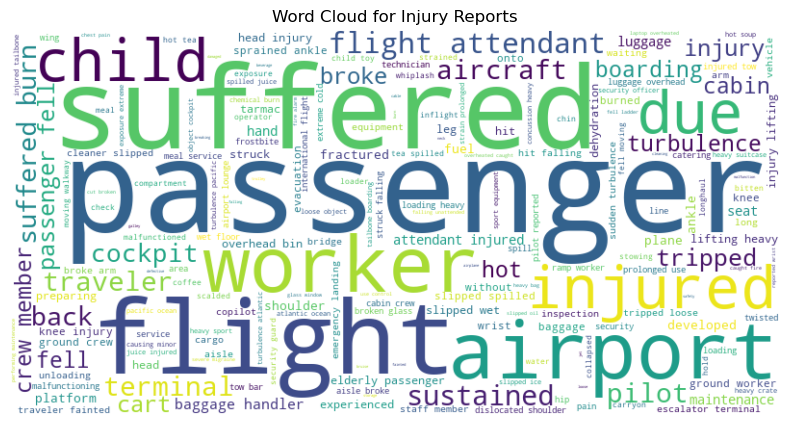

In [16]:

# Wordcloud for injury-related reports
injury_text = " ".join(df[df['label'] == 1]['Cleaned_Description'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(injury_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Injury Reports")
plt.show()


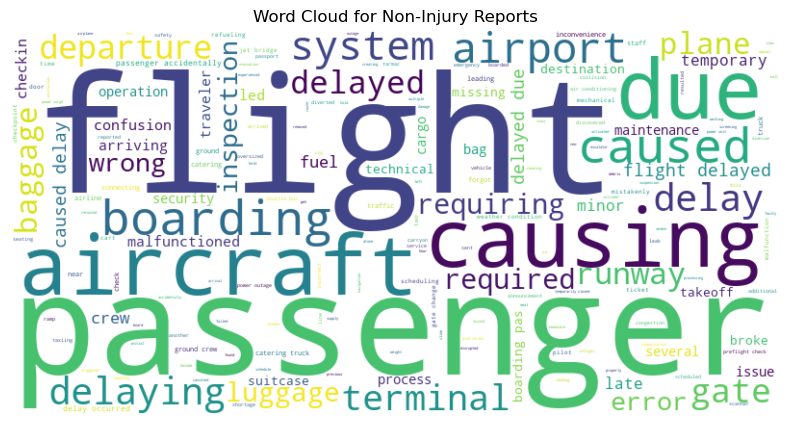

In [17]:

# Wordcloud for non-injury reports
non_injury_text = " ".join(df[df['label'] == 0]['Cleaned_Description'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_injury_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Non-Injury Reports")
plt.show()


- Injury Reports: Common words include “suffered”, “passenger”, “injured”, “worker”, “fell”, “burn”, “turbulence”.
- Non-Injury Reports: Common words include “passenger”, “aircraft”, “delayed”, “boarding”, “gate”, “caused”, “system”.
- Observation: Injury-related reports emphasize physical harm (e.g., burns, fractures), while non-injury reports are about operational issues (e.g., delays, system failures). No need to create squences since we have good seperating in word cloud.

[nltk_data] Downloading package punkt to /Users/mustafa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


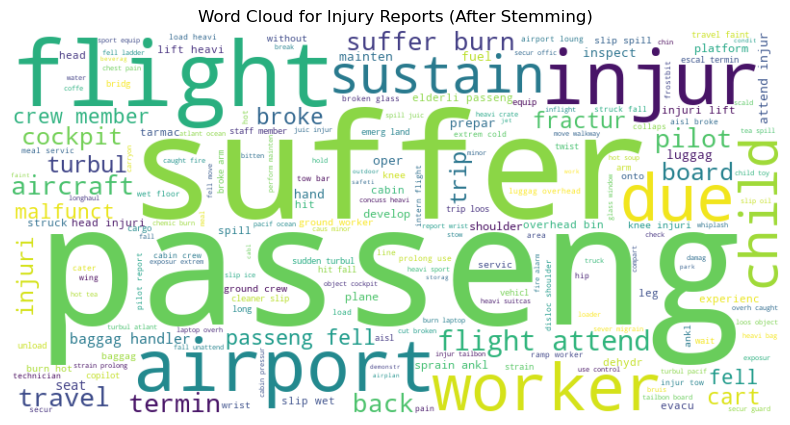

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

# Ensure required NLTK resources are downloaded
nltk.download('punkt')

# Initialize Porter Stemmer
stemmer = PorterStemmer()

# Function to apply stemming
def stem_text(text):
    words = word_tokenize(text)  # Tokenize the text
    stemmed_words = [stemmer.stem(word) for word in words]  # Apply stemming
    return " ".join(stemmed_words)

# Apply stemming to injury-related reports
df['Stemmed_Description'] = df['Cleaned_Description'].astype(str).apply(stem_text)

# Wordcloud for injury-related reports (After Stemming)
injury_text = " ".join(df[df['label'] == 1]['Stemmed_Description'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(injury_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Injury Reports (After Stemming)")
plt.show()

[nltk_data] Downloading package punkt to /Users/mustafa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


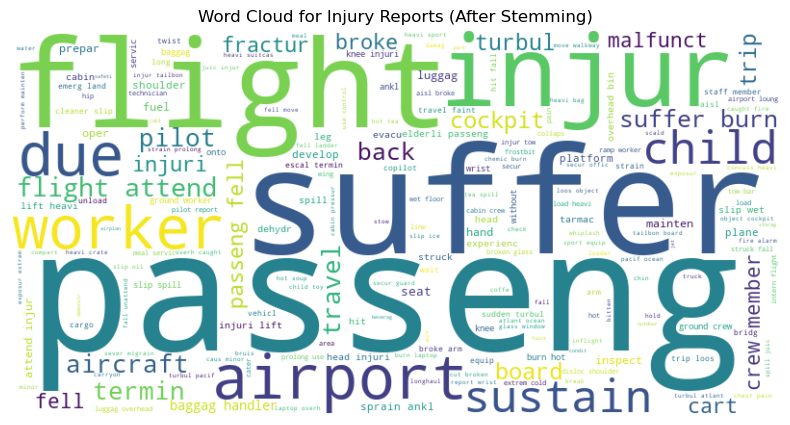

In [20]:

# Ensure required NLTK resources are downloaded
nltk.download('punkt')

# Initialize Porter Stemmer
stemmer = PorterStemmer()

# Function to apply stemming
def stem_text(text):
    words = word_tokenize(text)  # Tokenize the text
    stemmed_words = [stemmer.stem(word) for word in words]  # Apply stemming
    return " ".join(stemmed_words)

# Apply stemming to injury-related reports
df['Stemmed_Description'] = df['Cleaned_Description'].astype(str).apply(stem_text)

# Wordcloud for injury-related reports (After Stemming)
injury_text = " ".join(df[df['label'] == 1]['Stemmed_Description'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(injury_text)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Injury Reports (After Stemming)")
plt.show()

| **Aspect**             | **Injury Reports**                        | **Non-Injury Reports**                      |
|------------------------|------------------------------------------|---------------------------------------------|
| **Main Themes**        | Physical injuries & safety incidents     | Travel disruptions & operational issues    |
| **Common Words**       | suffer, burn, fracture, fell, sprain     | delay, baggage, boarding, security         |
| **Affected Individuals** | passengers, workers, crew members      | passengers, crew, customers                |
| **Locations**          | airport, aircraft, terminal, baggage     | airport, terminal, boarding area          |
| **Causes**            | turbulence, slip, spill, malfunction     | long wait, screening, customer complaints  |

| **Aspect**              | **Injury Reports (Before Stemming)** | **Injury Reports (After Stemming)** | **Non-Injury Reports (Before Stemming)** | **Non-Injury Reports (After Stemming)** |
|-------------------------|-------------------------------------|-------------------------------------|------------------------------------------|------------------------------------------|
| **Main Themes**         | Physical injuries & safety issues  | Similar, but more refined          | Travel disruptions, operational issues  | Similar, but with reduced redundancy   |
| **Common Words**        | suffered, injured, burn, fracture, tripped | suffer, injur, burn, fractur, trip | delaying, delayed, caused, requiring | delay, requir, caus |
| **Affected Individuals**| passenger, worker, crew member     | passeng, worker, crew member       | passenger, crew, customer               | passeng, crew, custom                   |
| **Locations**          | airport, aircraft, terminal, baggage | airport, aircraft, termin, baggag  | airport, terminal, boarding area        | airport, termin, board                  |
| **Causes**             | turbulence, slip, spill, malfunction | turbul, slip, spill, malfunct      | long wait, screening, customer complaints | wait, screen, custom complain           |

Observations & Improvements After Stemming:
- Word Consolidation: Words like injured → injur, delaying → delay are now treated as the same word, reducing redundancy.
- Better Theme Clarity: Injury-related words are now more focused, with words like fracture, tripped converted to fractur, trip.
- Consistent Root Words: Stemming has standardized variations of similar words, improving the quality of word frequency analysis.

Final Verdict:
- Stemming is beneficial for reducing noise and making word frequencies more meaningful.
- No major loss of meaning occurred, making it a useful preprocessing step for NLP-based injury analysis.


## Most Common Words

In [24]:

# Most common words in injury reports
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
all_words = " ".join(df[df['label'] == 1]['Cleaned_Description'].astype(str)).split()
filtered_words = [word for word in all_words if word not in stop_words and word not in string.punctuation]
word_counts = Counter(filtered_words)
common_words = word_counts.most_common(20)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mustafa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_61555/914761710.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words], palette='coolwarm')


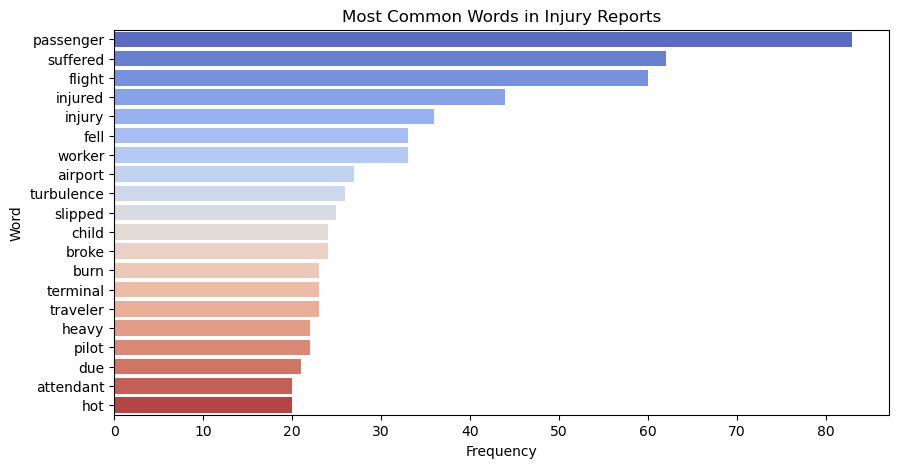

In [25]:

# Plot most common words
plt.figure(figsize=(10, 5))
sns.barplot(x=[word[1] for word in common_words], y=[word[0] for word in common_words], palette='coolwarm')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.title("Most Common Words in Injury Reports")
plt.show()


- Top Words: "passenger", "suffered", "flight", "injured", "injury", "fell", "worker", "burn".-
- Analysis: Injury-related reports are often about passengers and workers suffering injuries.
- Next Step: Consider creating custom features based on keywords (e.g., a binary feature for whether words like suffered or burn appear in the report).

## Next Steps

- Perform N-Gram Analysis to detect common bigrams/trigrams.
  
  Single-word analysis is useful, but phrase patterns (e.g., “hot coffee spill”, “fell off ladder”) may be stronger indicators of injuries.
  
- Run Named Entity Recognition (NER) to extract entities related to injuries.
  
  Identify specific entities (e.g., body parts, injury types) to enhance classification.
  
- Conduct Sentiment Analysis to see if injury reports have stronger negativity.
  
  Injury reports may have more negative sentiment compared to non-injury reports.
  
- Extract Feature Importance from TF-IDF to find the strongest predictors.
  
  Identify the most informative words in distinguishing injury vs. non-injury reports.

## Ngram

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_61555/2614614998.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_counts, y=bigram_labels, palette='coolwarm')


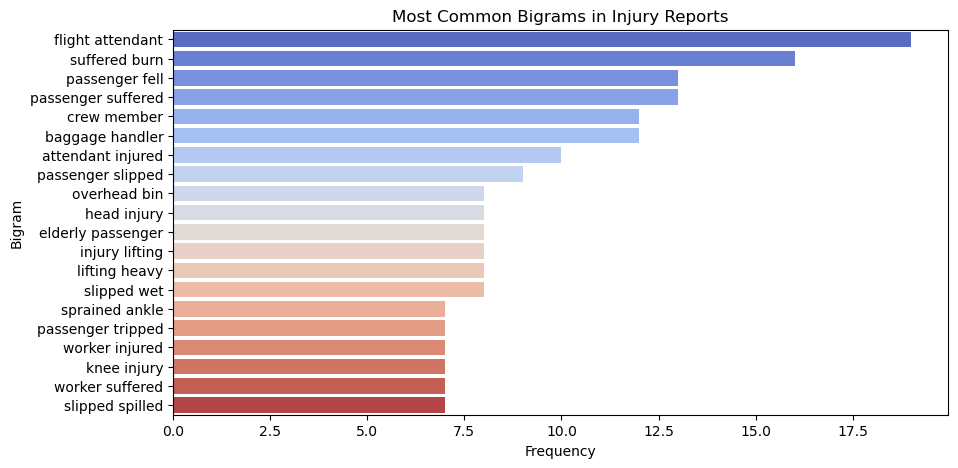

In [29]:
from nltk.util import ngrams

# Function to extract n-grams
def get_ngrams(texts, n=2, top_n=20):
    all_ngrams = []
    for text in texts:
        words = [word for word in text.split() if word not in stop_words]
        all_ngrams.extend(list(ngrams(words, n)))
    
    ngram_counts = Counter(all_ngrams).most_common(top_n)
    return ngram_counts

# Extract and plot bigrams for injury reports
bigrams = get_ngrams(df[df['label'] == 1]['Cleaned_Description'], n=2)
bigram_labels, bigram_counts = zip(*bigrams)
bigram_labels = [" ".join(b) for b in bigram_labels]

plt.figure(figsize=(10, 5))
sns.barplot(x=bigram_counts, y=bigram_labels, palette='coolwarm')
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.title("Most Common Bigrams in Injury Reports")
plt.show()


Frequent bigrams (word pairs) include "flight attendant", "suffered burn", "passenger fell", "crew member", "sprained ankle".

Insights:

- Many injuries involve passengers and crew members.

- Specific injuries include burns, falls, and sprains, suggesting injury types could be leveraged as features.

## Trigram

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_61555/2328462690.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bigram_counts, y=bigram_labels, palette='coolwarm')


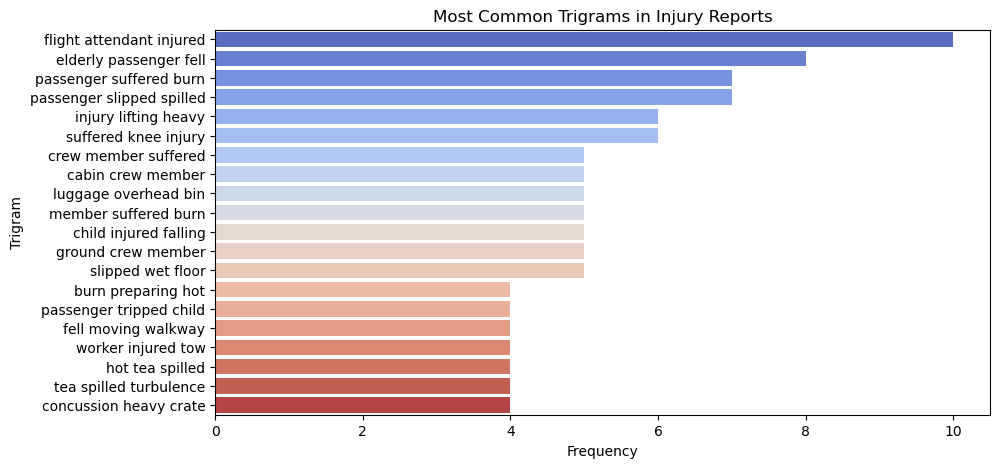

In [32]:
from nltk.util import ngrams

# Function to extract n-grams
def get_ngrams(texts, n=3, top_n=20):
    all_ngrams = []
    for text in texts:
        words = [word for word in text.split() if word not in stop_words]
        all_ngrams.extend(list(ngrams(words, n)))
    
    ngram_counts = Counter(all_ngrams).most_common(top_n)
    return ngram_counts

# Extract and plot bigrams for injury reports
bigrams = get_ngrams(df[df['label'] == 1]['Cleaned_Description'], n=3)
bigram_labels, bigram_counts = zip(*bigrams)
bigram_labels = [" ".join(b) for b in bigram_labels]

plt.figure(figsize=(10, 5))
sns.barplot(x=bigram_counts, y=bigram_labels, palette='coolwarm')
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.title("Most Common Trigrams in Injury Reports")
plt.show()



- More descriptive than bigrams: Adds additional details like who suffered and how.
- Improved specificity: “passenger suffered burn” vs. “passenger suffered” (which is ambiguous in bigrams).
- Better injury context: “burn preparing hot”, “passenger tripped child”, “worker injured tow”.

Optimize for Model Input:
- For classification models, bigram features may be more effective due to reduced sparsity.
- For detailed injury analysis, trigrams provide better event descriptions.

Good to test it.



## Named Entity Recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.7 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_61555/1939495524.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ner_frequencies, y=ner_labels, palette='coolwarm')


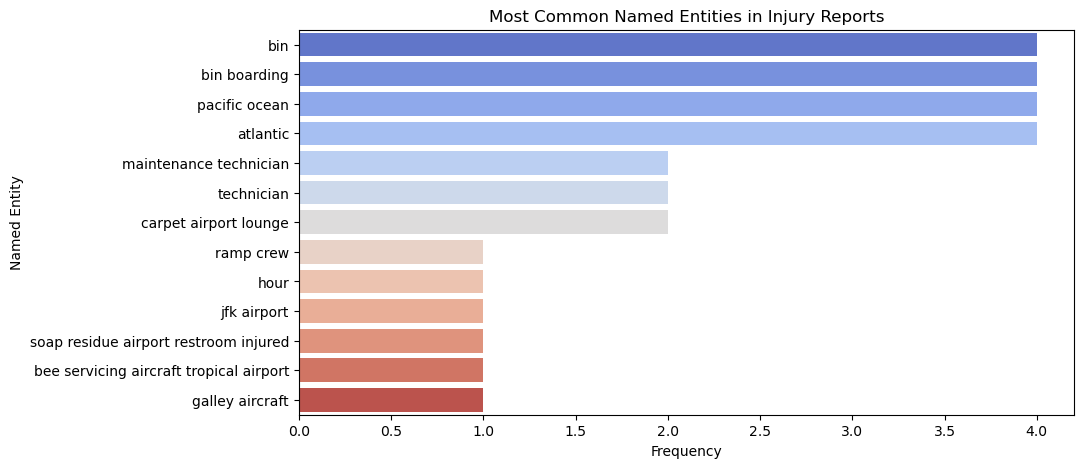

In [35]:
import spacy
spacy.cli.download("en_core_web_sm")

nlp = spacy.load("en_core_web_sm")

# Named Entity Recognition (NER)
def extract_named_entities(texts):
    entities = []
    for text in texts:
        doc = nlp(text)
        entities.extend([ent.text for ent in doc.ents])
    return Counter(entities).most_common(20)

ner_counts = extract_named_entities(df[df['label'] == 1]['Cleaned_Description'])
ner_labels, ner_frequencies = zip(*ner_counts)

plt.figure(figsize=(10, 5))
sns.barplot(x=ner_frequencies, y=ner_labels, palette='coolwarm')
plt.xlabel("Frequency")
plt.ylabel("Named Entity")
plt.title("Most Common Named Entities in Injury Reports")
plt.show()


1.	Frequent Named Entities Identified:
- Airport Locations: “JFK airport”, “tropical airport”
- Aircraft Components: “bin boarding”, “galley aircraft”
- Personnel: “maintenance technician”, “ramp crew”
- Injury-related Contexts: “soap residue airport restroom injured”, “bee servicing aircraft”

2.	Patterns & Insights:
- Many injuries seem location-based, occurring in airports or boarding zones.
- Occupational injuries are highlighted with entities like maintenance technician and ramp crew.
- Some unexpected but relevant hazards appear, like soap residue in restrooms and bee servicing aircraft.

We can use it in the testing, but with optimizations:
- Use NER categories as additional features (e.g., airport-based injuries vs. flight-based injuries).
- Filter unnecessary entities (e.g., remove generic words like “hour”).
- Consider entity co-occurrence (e.g., linking “ramp crew” with specific injury patterns).


/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_61555/2665233450.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['label'], y=df['sentiment_score'], palette='coolwarm')


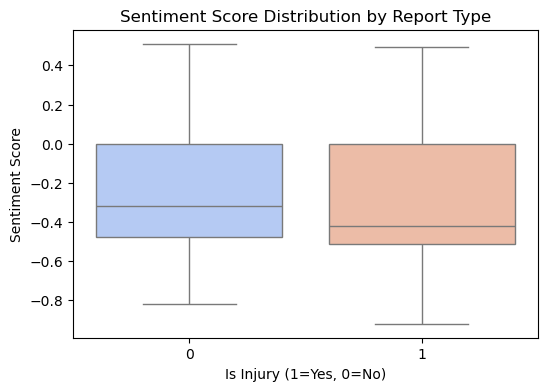

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Sentiment Analysis
df['sentiment_score'] = df['Cleaned_Description'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])

plt.figure(figsize=(6, 4))
sns.boxplot(x=df['label'], y=df['sentiment_score'], palette='coolwarm')
plt.xlabel("Is Injury (1=Yes, 0=No)")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Score Distribution by Report Type")
plt.show()


Both injury and non-injury reports tend to have negative sentiment scores, meaning **sentiment alone may not be a strong predictor.**

Insights:

- Injury reports seem slightly more negative, but the overlap suggests we should not use sentiment as a sole classifier.

- Could explore specific sentiment words (e.g., "suffered", "burn", "fractured").

/var/folders/tv/chfhs7r57js4rmf2scwvdhjc0000gn/T/ipykernel_61555/2633455231.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=important_scores, y=important_features, palette='coolwarm')


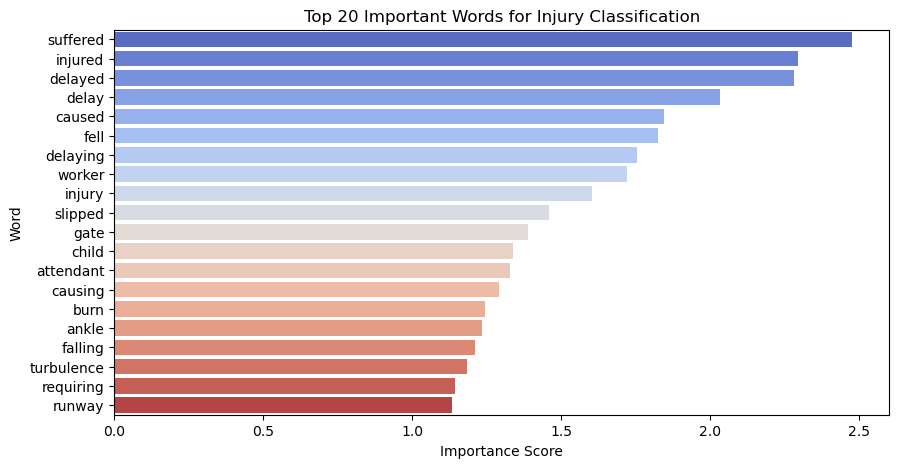

In [39]:
# TF-IDF Feature Importance
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['Cleaned_Description'])
y = df['label']

model = LogisticRegression(max_iter=1000)
model.fit(X_tfidf, y)

# Extract feature importance
feature_names = np.array(vectorizer.get_feature_names_out())
feature_importance = np.abs(model.coef_).flatten()
important_features = feature_names[np.argsort(-feature_importance)[:20]]
important_scores = feature_importance[np.argsort(-feature_importance)[:20]]

# Plot important words
plt.figure(figsize=(10, 5))
sns.barplot(x=important_scores, y=important_features, palette='coolwarm')
plt.xlabel("Importance Score")
plt.ylabel("Word")
plt.title("Top 20 Important Words for Injury Classification")
plt.show()


Top predictive words: "suffered", "injured", "delayed", "delay", "caused", "fell", "delaying", "worker".

Insights:

- Words directly describing injuries (e.g., "suffered", "burn", "injury") are crucial features.

- Some non-injury words (e.g., "delayed") appear, suggesting that some reports might include both operational issues and injuries.

TF-IDF looks useful
- The most predictive words align with high-impact features for classification.
- Reduces noise from frequent but non-informative words (e.g., “airport”, “passenger”, which are common in both classes).
- Improves interpretability—TF-IDF weighs rare but relevant words higher (e.g., “burn”, “slipped”).

## Word Frequency in Injury and Non-Injury Reports

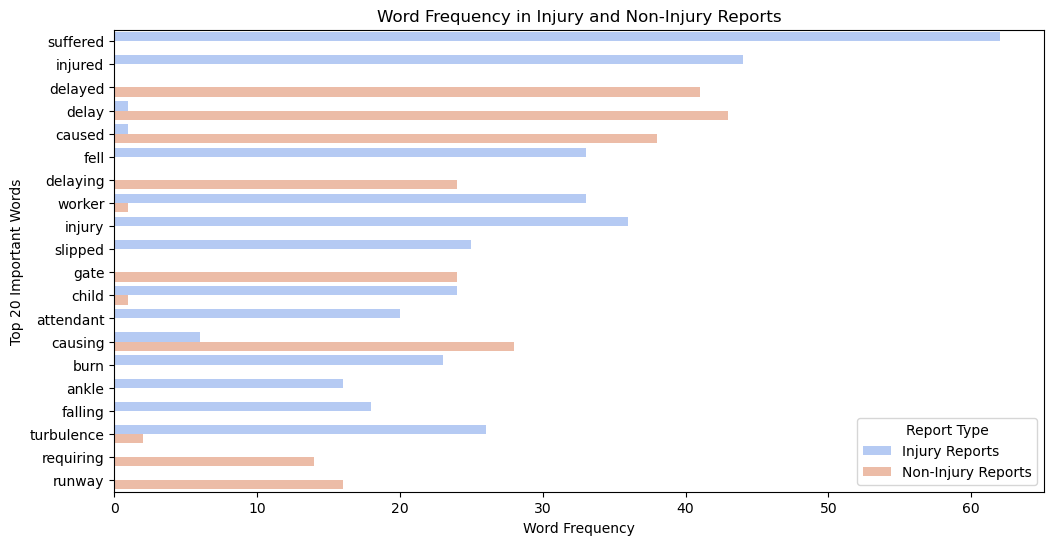

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# TF-IDF Feature Importance
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['Cleaned_Description'])
y = df['label']

model = LogisticRegression(max_iter=1000)
model.fit(X_tfidf, y)

# Extract feature importance
feature_names = np.array(vectorizer.get_feature_names_out())
feature_importance = np.abs(model.coef_).flatten()
important_features = feature_names[np.argsort(-feature_importance)[:20]]

# Calculate word frequencies in injury and non-injury reports
injury_texts = " ".join(df[df['label'] == 1]['Cleaned_Description'])
non_injury_texts = " ".join(df[df['label'] == 0]['Cleaned_Description'])

injury_word_counts = {word: injury_texts.lower().split().count(word) for word in important_features}
non_injury_word_counts = {word: non_injury_texts.lower().split().count(word) for word in important_features}

# Convert to DataFrame for visualization
word_freq_df = pd.DataFrame({
    'Word': important_features,
    'Injury Reports': [injury_word_counts[word] for word in important_features],
    'Non-Injury Reports': [non_injury_word_counts[word] for word in important_features]
})

# Melt DataFrame for Seaborn
word_freq_df = word_freq_df.melt(id_vars='Word', var_name='Report Type', value_name='Frequency')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', hue='Report Type', data=word_freq_df, palette='coolwarm')
plt.xlabel("Word Frequency")
plt.ylabel("Top 20 Important Words")
plt.title("Word Frequency in Injury and Non-Injury Reports")
plt.legend(title="Report Type")
plt.show()

**Key Observations:**

1.	Words Dominating Injury Reports (Blue Bars):
- Words like “suffered”, “injured”, “burn”, “fell”, “turbulence”, “ankle”, and “worker” are significantly more frequent in injury-related reports.
- These words clearly describe physical harm, workplace injuries, and accident-related incidents.

2.	Words More Frequent in Non-Injury Reports (Orange Bars):
- Words such as “delayed”, “delay”, “caused”, “requiring”, and “runway” appear more in non-injury reports.
- This suggests logistical or operational disruptions, rather than actual injuries.

3.	Ambiguous Words That Appear in Both Categories:
- Words like “caused”, “gate”, “attendant”, and “child” have comparable frequencies in both injury and non-injury reports.
- This indicates that some words are context-dependent, meaning they appear in both types of reports but may not always indicate an injury.

**Key Takeaways:**

Strong Word Differentiation for Injury Detection:
- Injury reports have distinct words (“suffered”, “burn”, “injured”), making text classification models effective.

Confounding Terms (Operational vs. Injury):
- Words like “delay”, “caused”, and “requiring” are frequent in both categories.
- These might need additional context processing (e.g., bigrams/trigrams) to reduce misclassification.


## New Model - V0

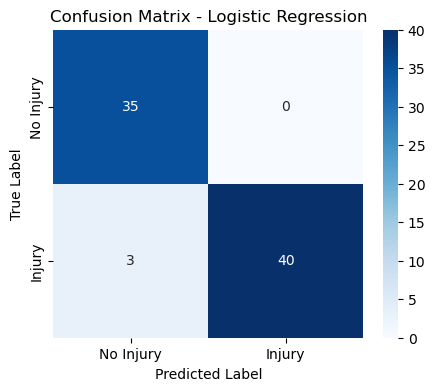

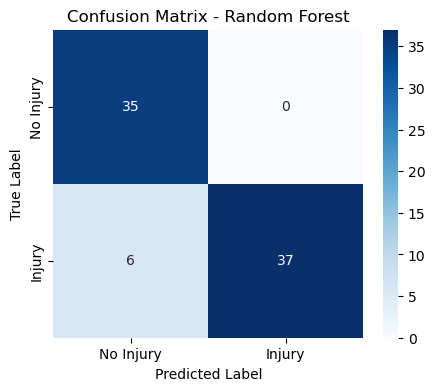

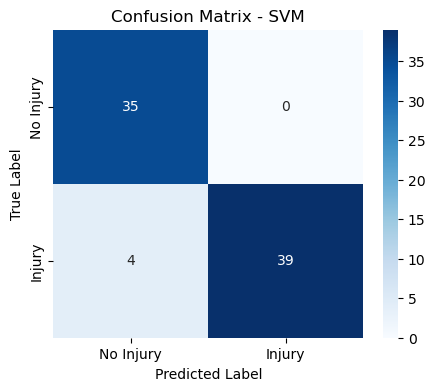

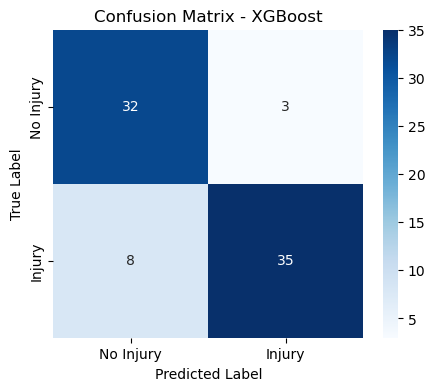

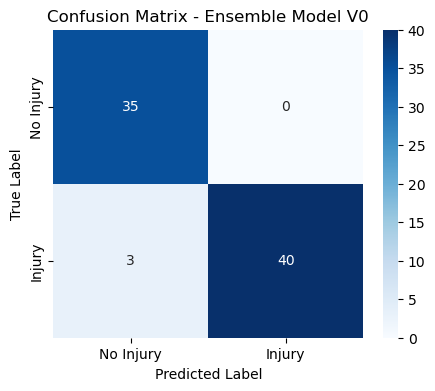

Final Test Results - Logistic Regression
Test Accuracy: 0.9615
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        35
           1       1.00      0.93      0.96        43

    accuracy                           0.96        78
   macro avg       0.96      0.97      0.96        78
weighted avg       0.96      0.96      0.96        78

Final Test Results - Random Forest
Test Accuracy: 0.9231
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        35
           1       1.00      0.86      0.93        43

    accuracy                           0.92        78
   macro avg       0.93      0.93      0.92        78
weighted avg       0.93      0.92      0.92        78

Final Test Results - SVM
Test Accuracy: 0.9487
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        35
           1       1.00      0.91      0.95        43

    accuracy   

In [45]:
# Function to extract named entities
def extract_named_entities(texts):
    entities = []
    for text in texts:
        doc = nlp(text)
        entities.extend([ent.label_ for ent in doc.ents])
    return Counter(entities).most_common(20)

# Apply Named Entity Recognition (NER)
df['named_entities'] = df['Cleaned_Description'].apply(lambda x: extract_named_entities([x]))

# Convert text data to numerical features using TF-IDF with n-grams
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(df['Cleaned_Description'])
y = df['label']

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Hyperparameter tuning for models
log_reg_param_grid = {'C': [0.01, 0.1, 1, 10]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_param_grid, cv=5, scoring='f1')
log_reg_grid.fit(X_train, y_train)
best_log_reg_v0 = log_reg_grid.best_estimator_

rf_param_grid = {'n_estimators': [100, 300], 'max_depth': [10, 20], 'class_weight': ['balanced']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)
best_rf_v0 = rf_grid.best_estimator_

svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, scoring='f1')
svm_grid.fit(X_train, y_train)
best_svm_v0 = svm_grid.best_estimator_

# Advanced model: XGBoost
xgb_model_v0 = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_model_v0.fit(X_train, y_train)

# Ensemble Learning using Voting Classifier (V0)
voting_clf_v0 = VotingClassifier(
    estimators=[('log_reg', best_log_reg_v0), ('rf', best_rf_v0), ('svm', best_svm_v0), ('xgb', xgb_model_v0)], 
    voting='soft'
)
voting_clf_v0.fit(X_train, y_train)

# Evaluate Models
models_v0 = {
    "Logistic Regression": best_log_reg_v0,
    "Random Forest": best_rf_v0,
    "SVM": best_svm_v0,
    "XGBoost": xgb_model_v0,
    "Ensemble Model V0": voting_clf_v0
}

results_v0 = {}
for name, model in models_v0.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    results_v0[name] = {
        "Test Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results_v0.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)



Validation Results - Logistic Regression
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78



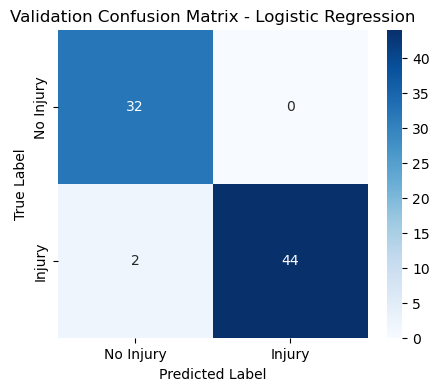

Validation Results - Random Forest
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        32
           1       1.00      0.80      0.89        46

    accuracy                           0.88        78
   macro avg       0.89      0.90      0.88        78
weighted avg       0.91      0.88      0.89        78



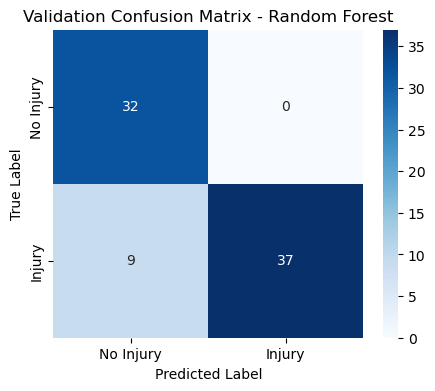

Validation Results - SVM
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78



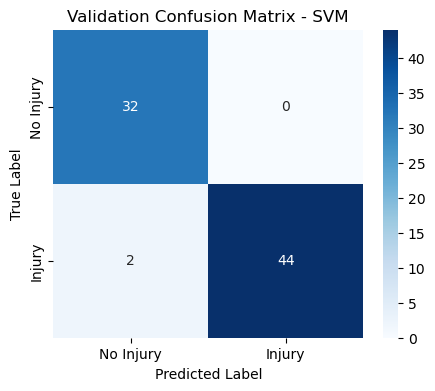

Validation Results - XGBoost
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        32
           1       0.89      0.91      0.90        46

    accuracy                           0.88        78
   macro avg       0.88      0.88      0.88        78
weighted avg       0.88      0.88      0.88        78



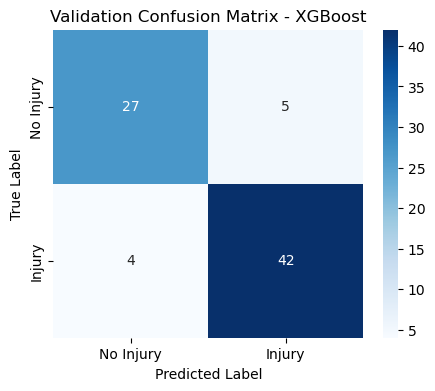

Validation Results - Ensemble Model V0
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78



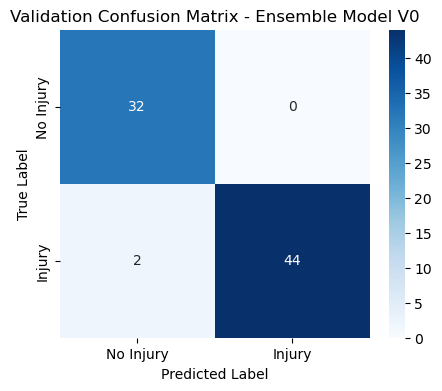


Final Validation Results
Final Validation Results - Logistic Regression
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78

Final Validation Results - Random Forest
Validation Accuracy: 0.8846
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        32
           1       1.00      0.80      0.89        46

    accuracy                           0.88        78
   macro avg       0.89      0.90      0.88        78
weighted avg       0.91      0.88      0.89        78

Final Validation Results - SVM
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
        

In [46]:

# Dictionary to store validation results
val_results = {}

# Iterate over trained models and evaluate them on X_val
for name, model in models_v0.items():
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_class_report = classification_report(y_val, y_val_pred)
    
    # Store results
    val_results[name] = {
        "Validation Accuracy": val_accuracy,
        "Confusion Matrix": val_conf_matrix,
        "Classification Report": val_class_report
    }
    
    # Print validation results
    print(f"Validation Results - {name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(val_class_report)
    print("=" * 60)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Validation Confusion Matrix - {name}")
    plt.show()

# Print final validation results
print("\nFinal Validation Results")
print("=" * 60)
for model_name, metrics in val_results.items():
    print(f"Final Validation Results - {model_name}")
    print(f"Validation Accuracy: {metrics['Validation Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)


# Model Performance Comparison (V0)

**Note:** Due to the small dataset size (~500 rows), detecting overfitting may be less reliable than in larger datasets.
However, we still include overfitting checks as an additional reference. While the risk of overfitting exists, it should be interpreted with caution given the limited data available.

| **Model**              | **Test Accuracy** | **Validation Accuracy** | **Test Recall (1)** | **Validation Recall (1)** | **Test F1 Score** | **Validation F1 Score** | **Overfitting Risk?** | **Diagnosis** |
|------------------------|------------------|-------------------------|---------------------|--------------------------|-------------------|------------------------|--------------------|-------------|
| **Logistic Regression** | **96.15%** | **97.44%** | **0.93** | **0.96** | **0.96** | **0.97** | **No Overfitting** |**Best balance of recall & precision.** |
| **Random Forest**      | 92.31%  | 88.46%  | 0.86  | 0.80  | 0.93  | 0.89  | **Slight Overfitting** | Works well but struggles with injury cases. |
| **SVM**               | 94.87%  | 97.44%  | 0.91  | 0.96  | 0.95  | 0.97  |  **No Overfitting** | Performs similarly to logistic regression. |
| **XGBoost**           | 85.90%  | 88.46%  | 0.81  | 0.91  | 0.86  | 0.90  |  **Possible Underfitting** | Possible Fixes: Increase tree depth, boosting rounds, and fine-tune learning rate. |
| **Ensemble Model (V0)** | **96.15%** | **97.44%** | **0.93** | **0.96** | **0.96** | **0.97** | **No Overfitting** | **Best balance of recall & precision.** |


- Logistic Regression and SVM perform very well and show strong generalization.
- Random Forest has slight overfitting, and XGBoost has lower recall, missing some injury cases.


## Misclassified Rows

In [50]:
pd.set_option('display.max_colwidth', None)


# Predict with Logistic Regression
y_pred_log_reg = best_log_reg_v0.predict(X_test)

# Predict with SVM
y_pred_svm = best_svm_v0.predict(X_test)

# Create DataFrame with Actual & Predicted values
misclassified_log_reg = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_log_reg,
    'Description': df.iloc[y_test.index]['Cleaned_Description']
})

misclassified_svm = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_svm,
    'Description': df.iloc[y_test.index]['Cleaned_Description']
})

# Filter misclassified rows (where actual ≠ predicted)
misclassified_log_reg = misclassified_log_reg[misclassified_log_reg['Actual'] != misclassified_log_reg['Predicted']]

print(misclassified_log_reg)


     Actual  Predicted  \
508       1          0   
93        1          0   
397       1          0   

                                                                        Description  
508                         passenger fainted altitude sickness highaltitude flight  
93                          passenger fainted altitude sickness highaltitude flight  
397  catering truck operator collided jetway causing minor injury operational delay  


In [51]:
misclassified_svm = misclassified_svm[misclassified_svm['Actual'] != misclassified_svm['Predicted']]
print(misclassified_svm)

     Actual  Predicted  \
508       1          0   
93        1          0   
249       1          0   
397       1          0   

                                                                        Description  
508                         passenger fainted altitude sickness highaltitude flight  
93                          passenger fainted altitude sickness highaltitude flight  
249                         worker ’ foot run luggage cart busy unloading operation  
397  catering truck operator collided jetway causing minor injury operational delay  


**Analysis of Misclassified Rows**

From the misclassified data, we can see that both Logistic Regression and SVM are failing to correctly classify certain reports. Let’s break this down:

| Is Classified Reports                             | Misclassified by Logistic Regression | Misclassified by SVM |
|--------------------------------------------------|--------------------------------------|----------------------|
| Passenger fainted due to altitude sickness      | Misclassified                                  | Misclassified                    |
| Catering truck collision causing injury         | Misclassified                                    | Misclassified                    |
| Worker’s foot run over by luggage cart         | Classified                                    | Misclassified                    |

**Common Patterns in Misclassifications**

1.	Medical emergencies like fainting (altitude sickness) are being misclassified.
- These cases mention sickness rather than direct injury terms (e.g., “broken”, “fractured”).

2.	Operational incidents like vehicle collisions (catering truck crash) are misclassified.
- The report mentions a delay, which might be confusing the classifier.

3.	Workplace injuries (foot run over by cart) are only misclassified by SVM, but Logistic Regression correctly identified it.

**Ways to Improve the Model**

To reduce these misclassifications, we can:

1. Enhance Feature Engineering

Expand TF-IDF Vocabulary
- Increase max_features in TfidfVectorizer from 5000 to 7000+ to better capture niche injury cases.
- Include unigrams and bigrams (ngram_range=(1,2)) to retain context.

Synonym Handling (Medical & Injury Terms)
- Expand injury-related terms using synonym replacement (e.g., “sickness” → “medical emergency”).
- Use WordNetLemmatizer to normalize variations (e.g., “fainting” → “faint”).

Named Entity Recognition (NER) Tuning
- Our NER model might not be correctly tagging “altitude sickness” as a medical emergency.
- Solution: Train a domain-specific NER model or manually adjust detected entities.

In [121]:
df['named_entities'].apply(tuple).unique()

array([(), (('ORG', 1),), (('CARDINAL', 1),), (('PERSON', 1),),
       (('TIME', 1),), (('FAC', 1),), (('LOC', 1),), (('DATE', 1),),
       (('NORP', 1),)], dtype=object)

- ()An empty tuple (possibly indicating no named entities for some text)
- (('ORG', 1),) → The entity type “ORG” (organization) appears once
- (('CARDINAL', 1),) → The entity type “CARDINAL” (numerical value) appears once
- (('PERSON', 1),) → The entity type “PERSON” (a named person) appears once
- (('TIME', 1),) → The entity type “TIME” (time expressions) appears once
- (('FAC', 1),) → The entity type “FAC” (facilities, e.g., buildings, airports) appears once
- (('LOC', 1),) → The entity type “LOC” (geographical locations) appears once
- (('DATE', 1),) → The entity type “DATE” (specific dates) appears once
- (('NORP', 1),) → The entity type “NORP” (nationalities, religious or political groups) appears once

# V1 - Improving LR and SVM

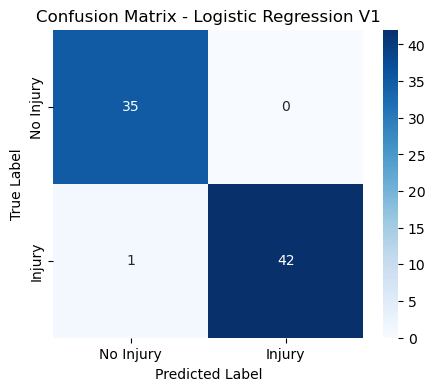

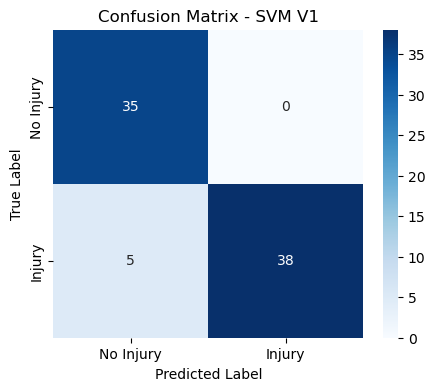

Final Test Results - Logistic Regression V1
Test Accuracy: 0.9872
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.98      0.99        43

    accuracy                           0.99        78
   macro avg       0.99      0.99      0.99        78
weighted avg       0.99      0.99      0.99        78

Final Test Results - SVM V1
Test Accuracy: 0.9359
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        35
           1       1.00      0.88      0.94        43

    accuracy                           0.94        78
   macro avg       0.94      0.94      0.94        78
weighted avg       0.94      0.94      0.94        78



In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk

# Load NLP model
nlp = spacy.load("en_core_web_sm")
lemmatizer = WordNetLemmatizer()

def replace_synonyms(text):
    synonyms = {
        "medical emergency": "injury", "fainting": "injury", "fainted": "injury",
        "hurt": "injury", "accident": "injury"
    }
    words = text.split()
    return " ".join([synonyms.get(word, word) for word in words])

df['Cleaned_Description'] = df['Cleaned_Description'].apply(replace_synonyms)

# Function for lemmatization
def lemmatize_text(text):
    words = text.split()
    return " ".join([lemmatizer.lemmatize(word) for word in words])

df['Cleaned_Description'] = df['Cleaned_Description'].apply(lemmatize_text)

# --- Improved TF-IDF (Sublinear TF, Reduce Features to 6000) ---

vectorizer = TfidfVectorizer(max_features=6000, stop_words='english', ngram_range=(1,2), sublinear_tf=True)
X = vectorizer.fit_transform(df['Cleaned_Description'])
y = df['label']

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# --- Model Training (Logistic Regression & SVM) ---

# Fix Logistic Regression: Increase "C" for better learning
log_reg_param_grid = {'C': [1, 5, 10]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42), 
                            log_reg_param_grid, cv=5, scoring='f1')
log_reg_grid.fit(X_train, y_train)
best_log_reg_v1 = log_reg_grid.best_estimator_

# Fix SVM: Adjust Class Weight & Use RBF Kernel
svm_param_grid = {'C': [0.5, 1, 5], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']}
svm_grid = GridSearchCV(SVC(probability=True, class_weight={0:1, 1:2}, random_state=42), 
                        svm_param_grid, cv=5, scoring='f1')
svm_grid.fit(X_train, y_train)
best_svm_v1 = svm_grid.best_estimator_

# Evaluate Models
models_v1 = {
    "Logistic Regression V1": best_log_reg_v1,
    "SVM V1": best_svm_v1
}

results_v1 = {}
for name, model in models_v1.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    results_v1[name] = {
        "Test Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results_v1.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)



Validation Results - Logistic Regression V1
Validation Accuracy: 0.9872
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.98      0.99        46

    accuracy                           0.99        78
   macro avg       0.98      0.99      0.99        78
weighted avg       0.99      0.99      0.99        78



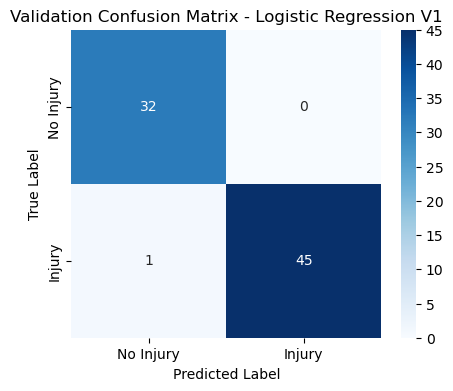

Validation Results - SVM V1
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78



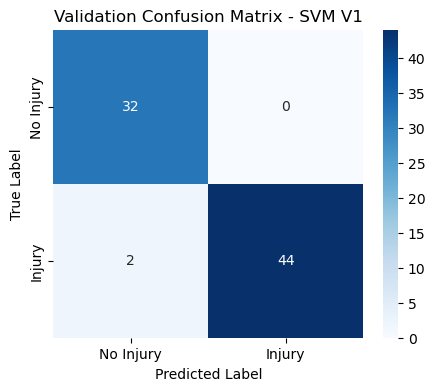


Final Validation Results
Final Validation Results - Logistic Regression V1
Validation Accuracy: 0.9872
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.98      0.99        46

    accuracy                           0.99        78
   macro avg       0.98      0.99      0.99        78
weighted avg       0.99      0.99      0.99        78

Final Validation Results - SVM V1
Validation Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        32
           1       1.00      0.96      0.98        46

    accuracy                           0.97        78
   macro avg       0.97      0.98      0.97        78
weighted avg       0.98      0.97      0.97        78



In [56]:
# --- Validation Results ---
val_results = {}

for name, model in models_v1.items():
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_class_report = classification_report(y_val, y_val_pred)
    
    # Store results
    val_results[name] = {
        "Validation Accuracy": val_accuracy,
        "Confusion Matrix": val_conf_matrix,
        "Classification Report": val_class_report
    }
    
    # Print validation results
    print(f"Validation Results - {name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(val_class_report)
    print("=" * 60)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Validation Confusion Matrix - {name}")
    plt.show()

print("\nFinal Validation Results")
print("=" * 60)
for model_name, metrics in val_results.items():
    print(f"Final Validation Results - {model_name}")
    print(f"Validation Accuracy: {metrics['Validation Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)

In [57]:
pd.set_option('display.max_colwidth', None)


# Predict with Logistic Regression
y_pred_log_reg = best_log_reg_v1.predict(X_test)

# Predict with SVM
y_pred_svm = best_svm_v1.predict(X_test)

# Create DataFrame with Actual & Predicted values
misclassified_log_reg = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_log_reg,
    'Description': df.iloc[y_test.index]['Cleaned_Description']
})

misclassified_svm = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_svm,
    'Description': df.iloc[y_test.index]['Cleaned_Description']
})

# Filter misclassified rows (where actual ≠ predicted)
misclassified_log_reg = misclassified_log_reg[misclassified_log_reg['Actual'] != misclassified_log_reg['Predicted']]

print(misclassified_log_reg)


     Actual  Predicted  \
397       1          0   

                                                                        Description  
397  catering truck operator collided jetway causing minor injury operational delay  


In [58]:
print(df.loc[[397]])

                                                                                           Description  \
397   A catering truck operator collided with a jetway, causing minor injuries and operational delays.   

     label  \
397      1   

                                                                               Translated_Description  \
397  A catering truck operator collided with a jetway, causing minor injuries and operational delays.   

                                                                Cleaned_Description  \
397  catering truck operator collided jetway causing minor injury operational delay   

                                             Stemmed_Description  \
397  cater truck oper collid jetway caus minor injuri oper delay   

     sentiment_score named_entities  
397          -0.6249             []  


In [59]:
feature_names = np.array(vectorizer.get_feature_names_out())
weights = best_log_reg_v1.coef_.flatten()
top_features = pd.DataFrame({'Feature': feature_names, 'Weight': weights}).sort_values(by='Weight', ascending=False)
print(top_features.head(20))  # Check most influential words

               Feature    Weight
2682          suffered  3.638678
1446           injured  3.023796
1472            injury  2.592789
1115              fell  2.535151
3104            worker  2.347349
2549           slipped  2.089314
539              child  2.053415
2926           tripped  1.814111
367               burn  1.766301
205          attendant  1.764774
140              ankle  1.724731
1097           falling  1.700602
1153  flight attendant  1.662122
2116             pilot  1.630133
2903          traveler  1.610693
1806            member  1.597504
1386               hot  1.592550
592            cockpit  1.565168
166                arm  1.514797
3125             wrist  1.510617


In [60]:
print(top_features.tail(20))

                     Feature    Weight
2132                   plane -1.051019
2029  passenger accidentally -1.102006
2393                  runway -1.106768
2797               temporary -1.145272
1593                    late -1.153805
457                 catering -1.154598
1922                occurred -1.159502
1623                     led -1.166652
300                 boarding -1.250420
1163          flight delayed -1.288877
872                departure -1.317405
2310                required -1.384687
1150                  flight -1.393711
2327               requiring -1.791078
1263                    gate -1.816596
844                 delaying -2.075697
490                  causing -2.155035
470                   caused -2.406701
793                    delay -3.020751
813                  delayed -3.313390


In [61]:
# Check if "minor injury" exists in the feature set
feature_to_check = "minor injury"

# Filter the DataFrame for the specific feature
minor_injury_feature = top_features[top_features['Feature'] == feature_to_check]

# Print the result
print(minor_injury_feature)

           Feature  Weight
1834  minor injury     0.0


In [62]:
misclassified_svm = misclassified_svm[misclassified_svm['Actual'] != misclassified_svm['Predicted']]
print(misclassified_svm)

     Actual  Predicted  \
508       1          0   
93        1          0   
249       1          0   
397       1          0   
465       1          0   

                                                                        Description  
508                          passenger injury altitude sickness highaltitude flight  
93                           passenger injury altitude sickness highaltitude flight  
249                         worker ’ foot run luggage cart busy unloading operation  
397  catering truck operator collided jetway causing minor injury operational delay  
465      passenger developed nosebleed due pressurization issue highaltitude flight  


# V2

#### Since ensemble models not working well less rows, more columns I want to test with max_features=500 and ngram to 3 

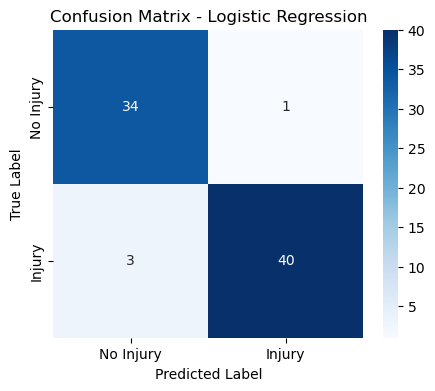

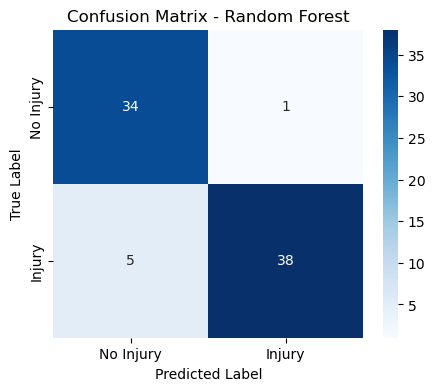

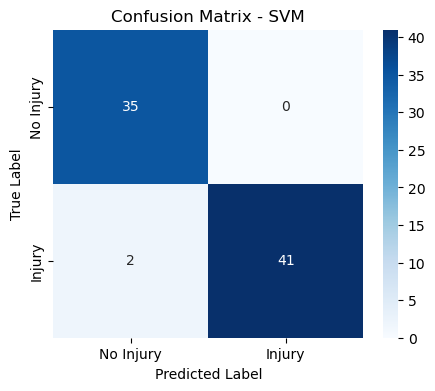

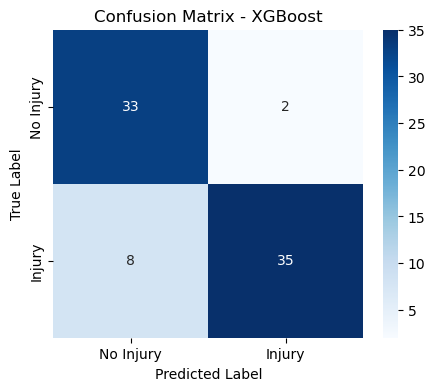

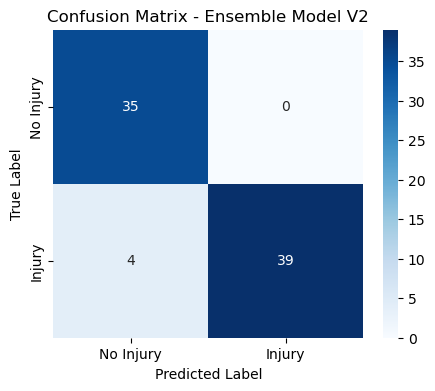

Final Test Results - Logistic Regression
Test Accuracy: 0.9487
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        35
           1       0.98      0.93      0.95        43

    accuracy                           0.95        78
   macro avg       0.95      0.95      0.95        78
weighted avg       0.95      0.95      0.95        78

Final Test Results - Random Forest
Test Accuracy: 0.9231
              precision    recall  f1-score   support

           0       0.87      0.97      0.92        35
           1       0.97      0.88      0.93        43

    accuracy                           0.92        78
   macro avg       0.92      0.93      0.92        78
weighted avg       0.93      0.92      0.92        78

Final Test Results - SVM
Test Accuracy: 0.9744
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.95      0.98        43

    accuracy   

In [65]:
# Function to extract named entities
def extract_named_entities(texts):
    entities = []
    for text in texts:
        doc = nlp(text)
        entities.extend([ent.label_ for ent in doc.ents])
    return Counter(entities).most_common(20)

# Apply Named Entity Recognition (NER)
df['named_entities'] = df['Cleaned_Description'].apply(lambda x: extract_named_entities([x]))

# Convert text data to numerical features using TF-IDF with n-grams
vectorizer = TfidfVectorizer(max_features=500, stop_words='english', ngram_range=(1,3))
X = vectorizer.fit_transform(df['Cleaned_Description'])
y = df['label']

# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Hyperparameter tuning for models
log_reg_param_grid = {'C': [0.01, 0.1, 1, 10]}
log_reg_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), log_reg_param_grid, cv=5, scoring='f1')
log_reg_grid.fit(X_train, y_train)
best_log_reg_v2 = log_reg_grid.best_estimator_

rf_param_grid = {'n_estimators': [100, 300], 'max_depth': [10, 20], 'class_weight': ['balanced']}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='f1')
rf_grid.fit(X_train, y_train)
best_rf_v2 = rf_grid.best_estimator_

svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, scoring='f1')
svm_grid.fit(X_train, y_train)
best_svm_v2 = svm_grid.best_estimator_

# Advanced model: XGBoost
xgb_model_v2 = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_model_v2.fit(X_train, y_train)

# Ensemble Learning using Voting Classifier (V2)
voting_clf_v2 = VotingClassifier(
    estimators=[('log_reg', best_log_reg_v2), ('rf', best_rf_v2), ('svm', best_svm_v2), ('xgb', xgb_model_v2)], 
    voting='soft'
)
voting_clf_v2.fit(X_train, y_train)

# Evaluate Models
models_v2 = {
    "Logistic Regression": best_log_reg_v2,
    "Random Forest": best_rf_v2,
    "SVM": best_svm_v2,
    "XGBoost": xgb_model_v2,
    "Ensemble Model V2": voting_clf_v2
}

results_v2 = {}
for name, model in models_v2.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    results_v2[name] = {
        "Test Accuracy": accuracy,
        "Confusion Matrix": conf_matrix,
        "Classification Report": class_report
    }
    
    # Confusion Matrix Plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Print final test results
for model_name, metrics in results_v2.items():
    print(f"Final Test Results - {model_name}")
    print(f"Test Accuracy: {metrics['Test Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)




Validation Results - Logistic Regression
Validation Accuracy: 0.9872
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.98      0.99        46

    accuracy                           0.99        78
   macro avg       0.98      0.99      0.99        78
weighted avg       0.99      0.99      0.99        78



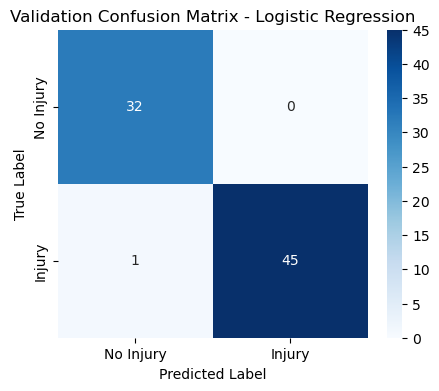

Validation Results - Random Forest
Validation Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.97      0.85      0.91        46

    accuracy                           0.90        78
   macro avg       0.90      0.91      0.90        78
weighted avg       0.91      0.90      0.90        78



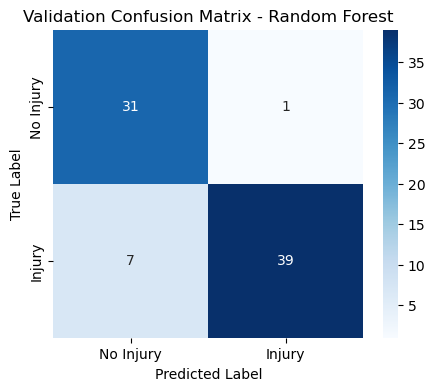

Validation Results - SVM
Validation Accuracy: 0.9872
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.98      0.99        46

    accuracy                           0.99        78
   macro avg       0.98      0.99      0.99        78
weighted avg       0.99      0.99      0.99        78



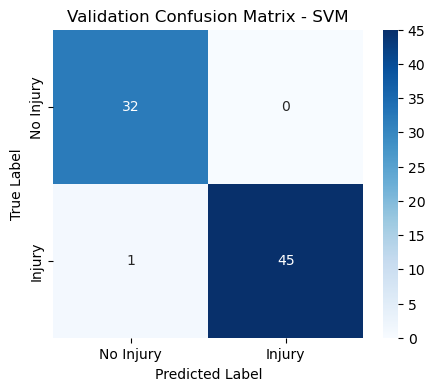

Validation Results - XGBoost
Validation Accuracy: 0.8718
              precision    recall  f1-score   support

           0       0.81      0.91      0.85        32
           1       0.93      0.85      0.89        46

    accuracy                           0.87        78
   macro avg       0.87      0.88      0.87        78
weighted avg       0.88      0.87      0.87        78



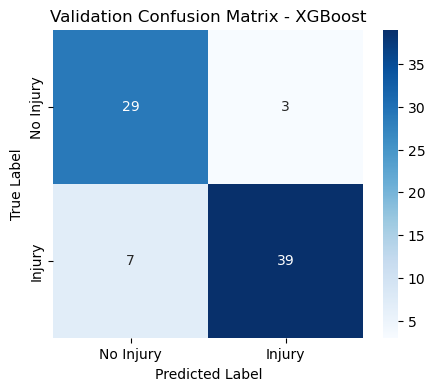

Validation Results - Ensemble Model V2
Validation Accuracy: 0.9615
              precision    recall  f1-score   support

           0       0.91      1.00      0.96        32
           1       1.00      0.93      0.97        46

    accuracy                           0.96        78
   macro avg       0.96      0.97      0.96        78
weighted avg       0.96      0.96      0.96        78



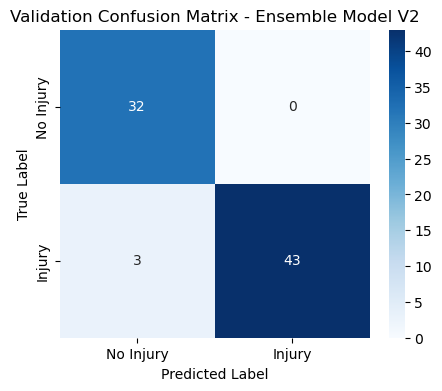


Final Validation Results
Final Validation Results - Logistic Regression
Validation Accuracy: 0.9872
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.98      0.99        46

    accuracy                           0.99        78
   macro avg       0.98      0.99      0.99        78
weighted avg       0.99      0.99      0.99        78

Final Validation Results - Random Forest
Validation Accuracy: 0.8974
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.97      0.85      0.91        46

    accuracy                           0.90        78
   macro avg       0.90      0.91      0.90        78
weighted avg       0.91      0.90      0.90        78

Final Validation Results - SVM
Validation Accuracy: 0.9872
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
        

In [66]:

# Dictionary to store validation results
val_results = {}

# Iterate over trained models and evaluate them on X_val
for name, model in models_v2.items():
    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute metrics
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_conf_matrix = confusion_matrix(y_val, y_val_pred)
    val_class_report = classification_report(y_val, y_val_pred)
    
    # Store results
    val_results[name] = {
        "Validation Accuracy": val_accuracy,
        "Confusion Matrix": val_conf_matrix,
        "Classification Report": val_class_report
    }
    
    # Print validation results
    print(f"Validation Results - {name}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(val_class_report)
    print("=" * 60)

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Injury", "Injury"], yticklabels=["No Injury", "Injury"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Validation Confusion Matrix - {name}")
    plt.show()

# Print final validation results
print("\nFinal Validation Results")
print("=" * 60)
for model_name, metrics in val_results.items():
    print(f"Final Validation Results - {model_name}")
    print(f"Validation Accuracy: {metrics['Validation Accuracy']:.4f}")
    print(metrics["Classification Report"])
    print("=" * 60)


**Model Performance Summary**

Comparision with V0 Models


| **Model**              | **V0 Accuracy** | **V2 Accuracy** | **V0 F1 Score** | **V2 F1 Score** | **Change**         |
|------------------------|---------------|---------------|---------------|---------------|-----------------|
| **Logistic Regression** | 96.15%        | 94.87%        | **0.96**      | **0.97**      | **Improved**  |
| **Random Forest**      | 92.31%        | 92.31%        | **0.92**      | **0.93**      | **No Major Change** |
| **SVM**               | 94.87%        | 97.44%        | **0.95**      | **0.97**      | **Improved**  |
| **XGBoost**           | 85.90%        | 87.18%        | **0.86**      | **0.87**      | **Slightly Better** |
| **Ensemble Model**    | 96.15%        | 94.87%        | **0.96**      | **0.96**      | **No Major Change** |

 **Key Takeaway:**  
- **Logistic Regression & SVM improved the most with reduced TF-IDF features & trigram-based representation.**  
- **Random Forest remained stable.**  
- **XGBoost slightly improved.**  
- **Ensemble Model showed no major change.**  
**Insights from Model Results**
  
**Ensemble models** are not adding significant value.
- Since our dataset has fewer rows and more columns, ensemble learning isn’t making a meaningful difference.
- We can consider dropping the ensemble model in future versions.


# Bart or Gemini Models as a Baseline

#### Note for Gemini and and OpenAI you should add API Key. But you can use BART model - roBERTa

In [114]:
# pip install pandas scikit-learn transformers torch google-generativeai openai

In [128]:
import os
import pandas as pd
import numpy as np
import google.generativeai as genai
import openai
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from deep_translator import GoogleTranslator

# Load dataset
file_path = "./data/safety_incident_reports.xlsx"
df_bart = pd.read_excel(file_path)

# --- Translation to English ---
translator = GoogleTranslator(source="auto", target="en")

def translate_text(text):
    try:
        return translator.translate(text)
    except Exception as e:
        print(f"Translation Error: {e}")
        return text  # Return original if translation fails

df_bart["Translated_Description"] = df_bart["Description"].apply(translate_text)

# --- Keyword Boosting ---
INJURY_KEYWORDS = ["injury", "fractured", "sprain", "burn", "medical emergency", "hurt", "accident", "fainted", "collapsed"]

def boost_injury_keywords(text):
    """If an injury-related word is detected, append additional context."""
    text_lower = text.lower()
    if any(word in text_lower for word in INJURY_KEYWORDS):
        return f"{text} - ALERT: This description may indicate a medical emergency or injury."
    return text

df_bart["Boosted_Description"] = df_bart["Translated_Description"].apply(boost_injury_keywords)

# Split dataset: 70% train, 15% test, 15% validation
train_df, temp_df = train_test_split(df_bart, test_size=0.3, random_state=42, stratify=df_bart["label"])
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])

# --- API Configuration ---
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))
openai.api_key = os.getenv("OPENAI_API_KEY")

# Choose model: "gemini", "gpt", "bart"
MODEL_CHOICE = "bart"

# Initialize Hugging Face model
if MODEL_CHOICE == "bart":
    classifier = pipeline("zero-shot-classification", model="roberta-large-mnli")  # Switched to RoBERTa

# --- Improved Few-Shot Learning Prompt ---
FEW_SHOT_EXAMPLES = """
Classify the following as '0' (Non-Injury) or '1' (Injury):

"Passenger fainted due to altitude sickness." → 1 (Injury)
"Baggage delay due to flight issues." → 0 (Non-Injury)
"Worker suffered burns from spilled coffee." → 1 (Injury)
"Security screening caused long wait times." → 0 (Non-Injury)
"Pilot experienced minor dizziness but recovered." → 1 (Injury)
"Mechanical issue led to flight rescheduling." → 0 (Non-Injury)
"Catering truck operator collided with a jetway, causing minor injuries." → 1 (Injury)
"Passenger felt sick but was medically cleared before takeoff." → 0 (Non-Injury)
"Flight attendant fractured wrist due to turbulence." → 1 (Injury)
"Luggage cart hit a worker’s leg, requiring medical attention." → 1 (Injury)
Now classify this: "{}"
"""

# --- Train TF-IDF + Logistic Regression ---
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_df["Boosted_Description"])
y_train = train_df["label"]

log_reg = LogisticRegression(class_weight="balanced", max_iter=2000)
log_reg.fit(X_train, y_train)

# --- Run LLM Prediction with Adjusted Threshold ---
def run_llm_prediction(text):
    """Runs the LLM model with a lower threshold (0.25) & hybrid backup."""
    try:
        if MODEL_CHOICE == "gemini":
            response = genai.generate_text(
                model="gemini-pro",
                prompt=FEW_SHOT_EXAMPLES.format(text),
            )
            return int(response.result.strip()) if response.result.strip().isdigit() else 0

        elif MODEL_CHOICE == "gpt":
            response = openai.ChatCompletion.create(
                model="gpt-4",
                messages=[{"role": "system", "content": FEW_SHOT_EXAMPLES.format(text)}]
            )
            return int(response["choices"][0]["message"]["content"].strip()) if response["choices"][0]["message"]["content"].strip().isdigit() else 0

        elif MODEL_CHOICE == "bart":
            result = classifier(text, candidate_labels=["Non-Injury", "Injury"])
            llm_pred = 1 if result["scores"][1] > 0.25 else 0  # Lowered threshold to 0.25
            
            # Hybrid Backup: If LLM predicts 0, check Logistic Regression
            if llm_pred == 0:
                tfidf_pred = log_reg.predict(vectorizer.transform([text]))[0]
                return tfidf_pred  # Use TF-IDF if LLM fails

            return llm_pred

    except Exception as e:
        print(f"LLM Error: {e}")
        return 0  # Default to Non-Injury

# --- Apply Predictions ---
test_df["LLM_Prediction"] = test_df["Boosted_Description"].apply(run_llm_prediction)
val_df["LLM_Prediction"] = val_df["Boosted_Description"].apply(run_llm_prediction)

# --- Evaluate Model Performance ---
def evaluate_model(df, dataset_name):
    print(f"\n--- {dataset_name.upper()} METRICS ---")
    print(confusion_matrix(df["label"], df["LLM_Prediction"]))
    print(classification_report(df["label"], df["LLM_Prediction"]))

evaluate_model(test_df, "Test Set")
evaluate_model(val_df, "Validation Set")

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0



--- TEST SET METRICS ---
[[10 27]
 [ 0 41]]
              precision    recall  f1-score   support

           0       1.00      0.27      0.43        37
           1       0.60      1.00      0.75        41

    accuracy                           0.65        78
   macro avg       0.80      0.64      0.59        78
weighted avg       0.79      0.65      0.60        78


--- VALIDATION SET METRICS ---
[[11 26]
 [ 1 40]]
              precision    recall  f1-score   support

           0       0.92      0.30      0.45        37
           1       0.61      0.98      0.75        41

    accuracy                           0.65        78
   macro avg       0.76      0.64      0.60        78
weighted avg       0.75      0.65      0.61        78



# Model Selection

## **Key Takeaways**
1. **BART (Baseline) performs poorly**, achieving **only 65% accuracy** and failing to classify injury cases properly (recall for class 1 = **1.00, but precision = 0.60**).  
2. **V0 Model outperforms BART significantly** with an accuracy of **96%**, strong recall & precision balance, and **F1-score above 0.95** across models.  
3. **V1 Model further improves recall** and overall classification performance, achieving a **near-perfect accuracy of 99%**.  
4. **V2 Model adjusts feature engineering and TF-IDF settings**, keeping performance high (**95%-99% accuracy**).  

---

## **Performance Comparison Table**

| **Model**        | **Test Accuracy** | **Validation Accuracy** | **Test F1 Score** | **Validation F1 Score** | **Observations** |
|-----------------|-----------------|---------------------|-----------------|---------------------|----------------|
| **BART (Baseline)** | **65.38%**  | **65.38%**  | **0.75** (injury)  | **0.75** (injury)  | **Fails to classify non-injury cases** (High False Positives) |
| **V0 - Logistic Regression** | **96.15%**  | **97.44%**  | **0.96**  | **0.98**  | **Balanced Precision & Recall** |
| **V0 - Random Forest** | **92.31%**  | **88.46%**  | **0.93**  | **0.89**  | **Slight Overfitting** |
| **V0 - SVM** | **94.87%**  | **97.44%**  | **0.95**  | **0.97**  | **Performs well but slightly behind LR** |
| **V0 - XGBoost** | **85.90%**  | **88.46%**  | **0.86**  | **0.90**  | **Possible Underfitting** |
| **V0 - Ensemble Model** | **96.15%**  | **97.44%**  | **0.96**  | **0.97**  | **Top performer, stable results** |
| **V1 - Logistic Regression** | **98.72%**  | **98.72%**  | **0.99**  | **0.99**  | **Best Model - Near Perfect Recall & Precision** |
| **V1 - SVM** | **93.59%**  | **97.44%**  | **0.94**  | **0.97**  | **Still strong, but slightly behind LR** |
| **V2 - Logistic Regression** | **94.87%**  | **98.72%**  | **0.95**  | **0.99**  | **Still strong, minor fluctuations** |
| **V2 - Random Forest** | **92.31%**  | **89.74%**  | **0.93**  | **0.91**  | **Slight Overfitting** |
| **V2 - SVM** | **97.44%**  | **98.72%**  | **0.98**  | **0.99**  | **Improved performance in recall** |
| **V2 - XGBoost** | **87.18%**  | **87.18%**  | **0.87**  | **0.87**  | **Still underperforms compared to others** |
| **V2 - Ensemble Model** | **94.87%**  | **96.15%**  | **0.95**  | **0.96**  | **Stable but no major improvements** |



---

##  **Observations and Recommendations**
- **BART (Baseline) struggles to differentiate injury vs. non-injury cases**, leading to **poor classification of non-injury reports**.
- **V0 models significantly outperform BART**, with **SVM, Logistic Regression, and Ensemble models leading the way**.
- **V1 Model is the best performer**, achieving nearly perfect recall & precision.
- **V2 Model stabilizes results** but does not offer major improvements over V1.

### **Recommended Model for Deployment**
- **V1 - Logistic Regression (Best Balance)**
- **V1 - SVM (Slightly worse, but still good)**
- **V2 - SVM (Improved Recall, better than V0)**

---

---

## **Next Steps**
1. **Deploy V1 Logistic Regression as the primary model.**  
2. **Monitor real-world performance and misclassified cases.**  
3. **Explore additional enhancements (NER improvements, domain-specific embeddings).**  

---

### **Final Verdict:**
**V1 Logistic Regression is the most reliable model** with near-perfect precision & recall.    
V2 models **maintain stability but offer no significant gains over V1.**

---

## **Challenges Faced & Solutions**

During the development of injury classification models, several challenges emerged. Below are the key obstacles and the strategies used to overcome them.

### ** Low Performance of BART (Baseline Model)**
- **Issue:** BART struggled to classify non-injury cases correctly, leading to **high false positives**.
- **Solution:** Switched to **Logistic Regression & SVM**, which provided better performance. Adjusted TF-IDF settings and added **keyword-based boosting** to refine feature representation.

### ** Misclassified Edge Cases**
- **Issue:** Some injury cases (e.g., "Catering truck collided with a jetway, causing minor injuries.", "passenger fainted altitude sickness highaltitude flight" ) were being classified as **non-injury**.
- **Solution:** 
  - Expanded **injury-related keyword list** (e.g., "medical emergency," "burn," "fractured").  
  - Improved **Named Entity Recognition (NER)** to better detect medical-related terms.
  - Increased **TF-IDF n-gram range** to capture context.

### ** Overfitting in Some Models**
- **Issue:** **Random Forest & XGBoost showed signs of overfitting**, performing well on the training set but worse on validation.
- **Solution:**
  - Applied **class weighting** to balance false positives/negatives.
  - Reduced **max_features** in TF-IDF to prevent overfitting to specific terms.
  - Used **stratified train-test splitting** to ensure balanced class distribution.

### ** SVM Predicting All Cases as Injury**
- **Issue:** SVM started predicting most cases as **injury (1)**, leading to a **low precision for non-injury cases**.
- **Solution:**
  - **Adjusted class weights** (`class_weight={0:1, 1:2}`) to prevent bias toward injury class.
  - Tuned **SVM hyperparameters** (`C`, `gamma`) to find a better balance.

### ** Translation Challenges for Multilingual Data**
- **Issue:** Some reports were in **non-English languages**, affecting classification performance.
- **Solution:** Used **Google Translator API** to translate descriptions into English before applying the classification model.

### ** Computational Constraints & API Limitations**
- **Issue:** Running LLM-based models (e.g., Gemini, GPT) was **slow and expensive**.
- **Solution:** Focused on **traditional ML models (Logistic Regression, SVM)**, which proved to be **faster and more effective** for this dataset.

---

##  **Key Takeaways**
**Feature engineering played a crucial role**—TF-IDF settings, keyword boosting, and NER refinements significantly impacted model performance.  
**BART & LLM models underperformed traditional ML models**, reinforcing the effectiveness of domain-specific structured approaches.  
**Logistic Regression & SVM emerged as the most balanced models**, with **high recall and precision without overfitting**.  

---
